<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/PneumoNet_COVID_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import(Dense, GlobalAveragePooling2D, Input, Conv2D, Multiply, Add, Activation, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
IMG_SIZE=300
BATCH_SIZE=16

train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5523 images belonging to 3 classes.
Found 1379 images belonging to 3 classes.


In [4]:
from tensorflow.keras.layers import Concatenate

def cbam_block(feature_map, ratio=8):
  channel=int(feature_map.shape[-1])

  shared_dense_one=Dense(channel//ratio, activation='relu')
  shared_dense_two=Dense(channel)

  avg_pool=Lambda(lambda x:tf.reduce_mean(x,axis=[1,2],keepdims=True))(feature_map)
  max_pool=Lambda(lambda x:tf.reduce_max(x,axis=[1,2],keepdims=True))(feature_map)

  mlp_avg=shared_dense_two(shared_dense_one(avg_pool))
  mlp_max=shared_dense_two(shared_dense_one(max_pool))

  channel_attention=Activation('sigmoid')(Add()([mlp_avg, mlp_max]))
  channel_refined=Multiply()([feature_map, channel_attention])

  avg_pool_spatial=Lambda(lambda x:tf.reduce_mean(x,axis=-1,keepdims=True))(channel_refined)
  max_pool_spatial=Lambda(lambda x:tf.reduce_max(x,axis=-1,keepdims=True))(channel_refined)
  concat=Concatenate(axis=-1)([avg_pool_spatial,max_pool_spatial])

  spatial_attention=Conv2D(1,kernel_size=7,padding='same',activation='sigmoid')(concat)
  refined_feature=Multiply()([channel_refined,spatial_attention])

  return refined_feature

In [5]:
base_model=EfficientNetB3(include_top=False,weights='imagenet',input_shape=(IMG_SIZE, IMG_SIZE,3))
x=base_model.output
x=cbam_block(x)
x=GlobalAveragePooling2D()(x)
x=Dense(128, activation='relu')(x)
output=Dense(3, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=output)
model.compile(optimizer=Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,572,309 (44.14 MB)

 Trainable params: 11,485,006 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [6]:
history=model.fit(train_generator,
                  validation_data=val_generator,
                  epochs=50,
                  callbacks=[
                      EarlyStopping(patience=5, restore_best_weights=True),
                      ModelCheckpoint('cbam_effnetb3_final.h5',save_best_only=True)
                  ]
                )
model.save('cbam_effnetb3_final.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7490 - loss: 0.6496 

346/346 ━━━━━━━━━━━━━━━━━━━━ 5285s 15s/step - accuracy: 0.7493 - loss: 0.6488 - val_accuracy: 0.3299 - val_loss: 2.9282
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 255s 736ms/step - accuracy: 0.9518 - loss: 0.1426 - val_accuracy: 0.3437 - val_loss: 8.9945
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9649 - loss: 0.1104

346/346 ━━━━━━━━━━━━━━━━━━━━ 248s 717ms/step - accuracy: 0.9649 - loss: 0.1103 - val_accuracy: 0.3096 - val_loss: 1.5670
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 259s 709ms/step - accuracy: 0.9788 - loss: 0.0615 - val_accuracy: 0.3292 - val_loss: 3.6759
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 251s 726ms/step - accuracy: 0.9823 - loss: 0.0540 - val_accuracy: 0.3299 - val_loss: 4.7165
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 250s 722ms/step - accuracy: 0.9835 - loss: 0.0522 - val_accuracy: 0.2350 - val_loss: 5.3713
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 250s 723ms/step - accuracy: 0.9842 - loss: 0.0495 - val_accuracy: 0.5236 - val_loss: 2.7184
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 283s 819ms/step - accuracy: 0.9888 - loss: 0.0358 - val_accuracy: 0.3299 - val_loss: 6.3798


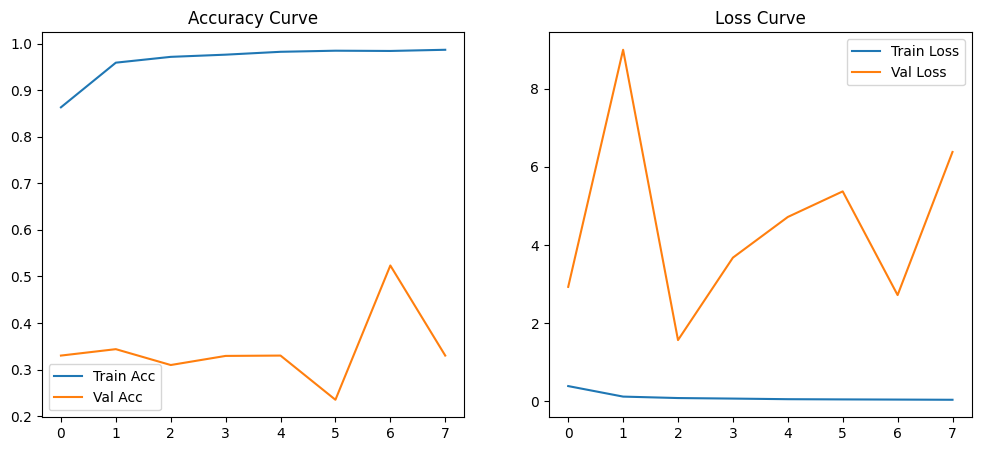

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curve')
plt.show()

86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 528ms/step


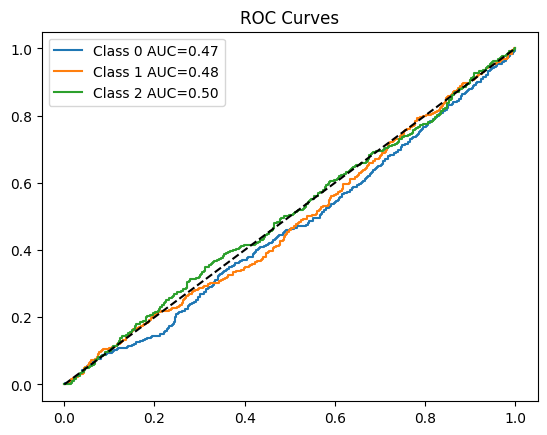

In [8]:
val_steps=val_generator.samples // val_generator.batch_size
y_true=val_generator.classes[:val_steps*BATCH_SIZE]
y_pred=model.predict(val_generator, steps=val_steps)
y_score=y_pred[:len(y_true)]
y_true_bin=label_binarize(y_true, classes=[0,1,2])

fpr={}; tpr={}; roc_auc={}
for i in range(3):
  fpr[i], tpr[i], _=roc_curve(y_true_bin[:,i], y_score[:,i])
  roc_auc[i]=auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
  plt.plot(fpr[i],tpr[i],label=f'Class {i} AUC={roc_auc[i]:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title('ROC Curves')
plt.show()

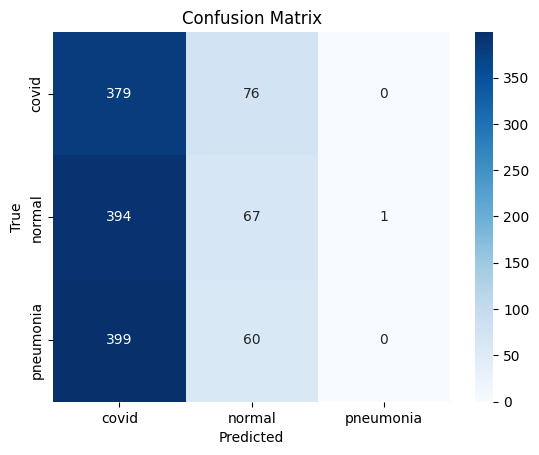

              precision    recall  f1-score   support

       covid       0.32      0.83      0.47       455
      normal       0.33      0.15      0.20       462
   pneumonia       0.00      0.00      0.00       459

    accuracy                           0.32      1376
   macro avg       0.22      0.33      0.22      1376
weighted avg       0.22      0.32      0.22      1376



In [9]:
y_pred_classes=np.argmax(y_score,axis=1)
cm=confusion_matrix(y_true,y_pred_classes)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=train_generator.class_indices,yticklabels=train_generator.class_indices)
plt.title('Confusion Matrix');plt.xlabel('Predicted');plt.ylabel('True')
plt.show()

print(classification_report(y_true,y_pred_classes,target_names=train_generator.class_indices))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image

# If you loaded/saved your model weights:
# model.load_weights('your_model_weights_path.h5')

# Map of class indices (match your generator's .class_indices or .classes attribute)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

img_size = 300  # As used in model input
root_dir = '/content/drive/MyDrive/Pneumonet'  # update if needed

# Helper: Load and preprocess an image file
def load_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)
    x = x / 255.0  # normalization matches train_datagen
    return x, img

# Helper: Get last conv layer -- adjust if you change model
last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

def make_gradcam_heatmap(img_array, model, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array,axis=0))
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0,1))
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())
    heatmap = np.maximum(heatmap, 0)  # Relu
    heatmap /= np.max(heatmap) + 1e-5  # Normalize
    heatmap = cv2.resize(heatmap, (img_size, img_size))
    return heatmap

def superimpose_heatmap(img, heatmap, alpha=0.5):
    img = np.array(img).astype(np.uint8)
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
    return superimposed_img

# For each class, collect correct predictions
examples_per_class = 2
correct_examples = {cls: [] for cls in idx_to_class.values()}

for cls_name, cls_idx in class_indices.items():
    folder_path = os.path.join(root_dir, cls_name)
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    np.random.shuffle(all_files)  # randomize to get diverse samples
    for file_path in all_files:
        img_arr, img_orig = load_preprocess_img(file_path)
        pred = model.predict(np.expand_dims(img_arr, axis=0))[0]
        pred_cls = np.argmax(pred)
        if pred_cls == cls_idx:
            correct_examples[cls_name].append((img_orig, img_arr, pred_cls, file_path))
            if len(correct_examples[cls_name]) >= examples_per_class:
                break

plt.figure(figsize=(12, 8))
plot_idx = 1
for cls, ex_list in correct_examples.items():
    for img_orig, img_arr, pred_cls, path in ex_list:
        heatmap = make_gradcam_heatmap(img_arr, model, pred_cls)
        overlay = superimpose_heatmap(img_orig, heatmap)
        plt.subplot(3, examples_per_class, plot_idx)
        plt.imshow(overlay)
        plt.axis('off')
        true_label = cls
        pred_label = idx_to_class[pred_cls]
        base = os.path.basename(path)
        plt.title(f'True: {true_label}\nPred: {pred_label}\n{base}', fontsize=8)
        plot_idx += 1
plt.suptitle("Grad-CAM: Per-Class / Only Correct Predictions", y=1.02, fontsize=17)
plt.tight_layout()
plt.show()

 Error: Could not read image at /content/drive/MyDrive/Pneumonet/covid/c1.png
 Error: Could not read image at /content/drive/MyDrive/Pneumonet/covid/c2.png
 Error: Could not read image at /content/drive/MyDrive/Pneumonet/normal/n1.png
 Error: Could not read image at /content/drive/MyDrive/Pneumonet/normal/n2.png
 Error: Could not read image at /content/drive/MyDrive/Pneumonet/pneumonia/p1.png
 Error: Could not read image at /content/drive/MyDrive/Pneumonet/pneumonia/p2.png
